
---
<big><big><big><big><big><big>Sieci neuronowe 2018/19</big></big></big></big></big></big>

---
<big><big><big><big><big>Model Isinga</big></big></big></big></big>

---

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use("fivethirtyeight")

#from bokeh.io import gridplot, output_file, show
#from bokeh.plotting import figure, output_notebook
#from bkcharts import Scatter

import random

In [ ]:
output_notebook()

In [ ]:
sns.set(font_scale=2.0)

Image inclusion
<img src="nn_figures/" width="100%">

# Model Isinga
1. jest modelem fizycznym leżącym u podstaw modeli Hopfielda czy Boltzmana
  * $x$ jest stanem modelu Isinga o $N$ spinach (wartości $+1$ lub $-1$)
  * jest wartością __sprzężenia__ między spinami $m$ i $n$
    * $J_{mn}$ jeśli __są__ sąsiadami
    * $0$ jeśli __nie są__ sąsiadami
  * energia stanu $x$ ($1/2$ ponieważ każdy stan jest liczony podwójnie)
  $$E(x; J, H)=-\frac{1}{2}\left(\sum_{m, n}J_{mn}x_mx_n+\sum_nHx_n\right)$$
  gdzie $H$ jest przyłożonym polem
    * jeśli $J>0$, to układ jest _ferromagnetykiem_
    * jeśli $J<0$, to _anty-ferromagnetykiem_
2. na model ma wpływ __temperatura__ (niech to bedzie ferromagnetyk)
  * gdy jest __wysoka__, to spiny są ukierunkowane losowo
  * gdy spada, lokalne zależności zaczynają przeważać
  * wraz z jej spadkiem w czasie, układ staje się stabilnym magnesem
  * prawdopodobieństwo dodatniego spinu jest określone przez
  $$P(+1\mid v_n)=\frac{1}{1+\exp(-2\beta v_n)}$$
  gdzie $\beta=1/(k_B T)$ gdzie $k_B$ jest stałą Boltzmanna ($k_B=1.38\times10^{-23}\;J/K$), a $T$ temperaturą
    * wysoka temperatura $T$ zwiększa losowość
3. alternatywą dla samplingu Gibbsa może być Metropolis, w którym określana jest zmiana energia wynikająca ze zmiany spinu
$$\Delta E=2x_nb_n$$ i przyjęcie nowego stanu z prawdopodobieństwem
$$P(\Delta E, \beta)=\begin{cases} 1 &\mbox{if } \Delta E\leq 0 \\ 
\exp(-\beta\Delta E) & \mbox{if } \Delta E>0 \end{cases}$$

## Sampling
Polityk szuka poparcia
1. odwiedza wyspy w swoim rejonie jedna po drugiej
2. każdego dnia wybiera sąsiednią wyspę porównując liczbę mieszkańców
  * jeśli sąsiednia wyspa ma ich więcej, to jedzie tam
  * jeśli ma mniej mieszkańców, to jedzie z prawdopodobieństwem $p=\dfrac{\text{liczba mieszkańców na sąsiedniej}}{\text{liczba mieszkańców na aktualnej}}$
  * z prawdopodobieństwem $1-p$ pozostaje na aktualnej
3. jeśli będzie to robił wystarczająco długo, to czas spędzony na każdej wyspie będzie __proporcjonalny__ do liczby mieszkańców
  * porównując liczbę mieszkańców tylko na sąsiednich wyspach dochodzi do estymacji na wszystkich!

## Próbkowanie Metropolis-Hastings
1. potrzebujemy losowania z rozkładu równomiernego, propozycji $p(x)$, docelowego posterior $g(x)$
  1. początkowy punkt startu $\theta$
  2. propozycja $\theta_p$ taka, że
  $$\begin{align}
  \theta_p&=\theta+\Delta\theta\\
  \Delta\theta&\sim\mathcal{N}(0,\sigma)
  \end{align}$$
  
  3. ułamek $$\rho=\frac{g(\theta_p\mid X)}{g(\theta\mid X)}$$
    * jeśli $\rho\geq1$, to $\theta=\theta_p$
    * jeśli $\rho<1$ to 
    
      * $\theta=\theta_p$ z prawdopodobieństwem $\rho$
      * w przeciwnym wypadku bez zmian $\theta=\theta$ (z prawdopodobieństwem $1-\rho$)
  
  * po pewnej liczbie kroków $\theta_k, \theta_{k+1}, \dots$ będą próbkami z rozkładu posterior
2. czemu to działa?
  * akceptujemy nowe $\theta_{k+1}$ kiedykolwiek gęstość prawdopodobieństwa docelowego rozkładu jest w $\theta_{k+1}$ jest większa niż w $\theta_k$
    * parametr $\theta$ będzie __częściej__ znajdywany w miejscach o większej gęstości
  * gdyby tak zawsze akceptować, to samplowanie utknęłoby w lokalnym minimum
    * akceptujemy ruchy do miejsc o mniejszej gęstości z szansą $\rho$
  * ponieważ $\rho$ jest ułamkiem, to mianowniki w
  $$g(\theta\mid X)=\frac{g(X\mid\theta)p(\theta)}{g(X)}$$ się upraszczają i wystarczają próbki z posterior $g(\theta\mid X)$
  * $\theta$ będzie spędzać czas proporcjonalnie do gęstości

In [2]:
def metropolis(start, target, proposal, niter):
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current)
        p = min(target(proposed) / target(current), 1)
        if np.random.random() < p:
            current = proposed
        post.append(current)
    return post

<img src="../nn_figures/metropolis.pdf" width="70%"> [McKay]
1. poziomo stany od 0 do 20; pionowo czas
2. sampling Metropolis-Hastings
3. histogram dla niezależnego losowania stanów z __docelowego__ rozkładu

1. proces rozpoczynał od stanu 10 i z równym rozkładem przechodził do lewego/prawego (przejście poza granicę było odrzucane)
> Reguła: jeśli największa skala w przestrzeni stanów wynosi $L$, a metoda Metropolis generuje propozycje z krokiem $\epsilon$, to algorytm musi być wykonany przez co najmniej $(L/\epsilon)^2$ iteracji dla osiągnięcia szeregu niezależnych próbek z rozkładu.

## Próbkowanie Gibbsa
1. niech $\theta=(\theta_1,\theta_2,\dots,\theta_k)$
2. potrafimy losować z rozkładów warunkowych $p(\theta_i\mid \theta_1,\dots,\theta_{i-1},\theta_{i+1},\dots,\theta_k,X)$
3. próbkujemy
  1. $\theta_i$ z rozkładów warunkowych traktując wszystkie inne parametry jako widzialne
    * przejście wszystkich parametrów oznacza jeden cykl
  2. w każdej iteracji proponowana jest nowa wartość konkretnego parametru wynikająca z jego rozkładu warunkowego
    * taka propozycja jest __zawsze__ akceptowana
    
4. nie ma potrzeby wyszukiwania coraz lepszych rozkładów propozycji
5. zalety i wady
  * propozycje są zawsze akceptowane
  * ale proces musi być zdolny generować rozkłady warunkowe i losowania z nich
  * może być powolny, jeśli parametry są skorelowane
<img src="../nn_figures/gibbs.pdf" width="70%"> [McKay]

In [3]:
def ising(T, wdth=64, max_turns=300):
    beta = 1.0 / T

    s= np.ones((wdth, wdth))
    for i in range(wdth):
        for j in range(wdth):
            if random.random() > 0.5:
                s[i, j] = -s[i, j]
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
    ax[0].pcolor(s)

    turns = 0
    dE = np.zeros((wdth, wdth))
    while turns < max_turns:
        turns = turns + 1
        for i in range(wdth):
            for j in range(wdth):
                dE[i, j] =  0.5 * 2 * s[i, j]*(s[(i - 1) % wdth, j] + s[(i + 1) % wdth, j] + s[i, (j - 1) % wdth] + s[i, (j + 1) % wdth])
                if dE[i, j]  < 0 or random.random() < np.exp(-2 * beta * dE[i, j]):
                    s[i, j] = - s[i, j]
    ax[1].pcolor(s)

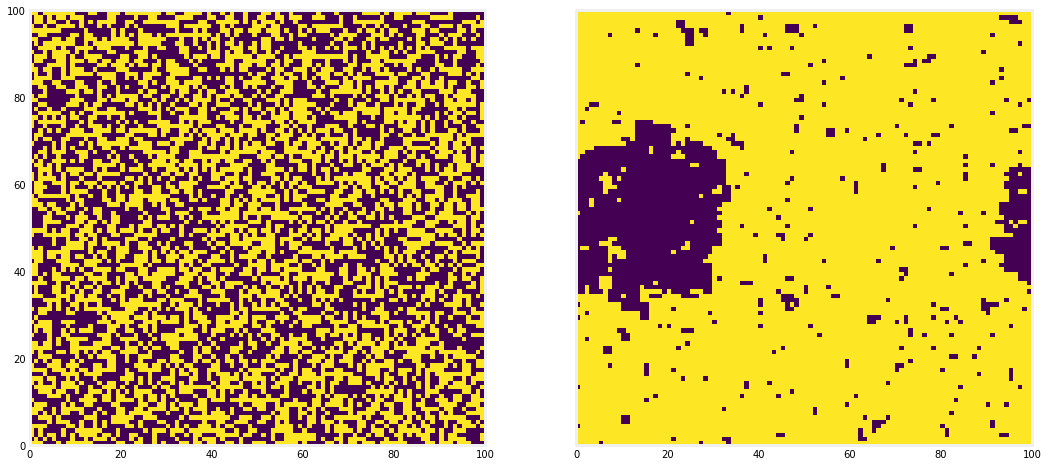

In [11]:
ising(T=2.0, wdth=100, max_turns=500)

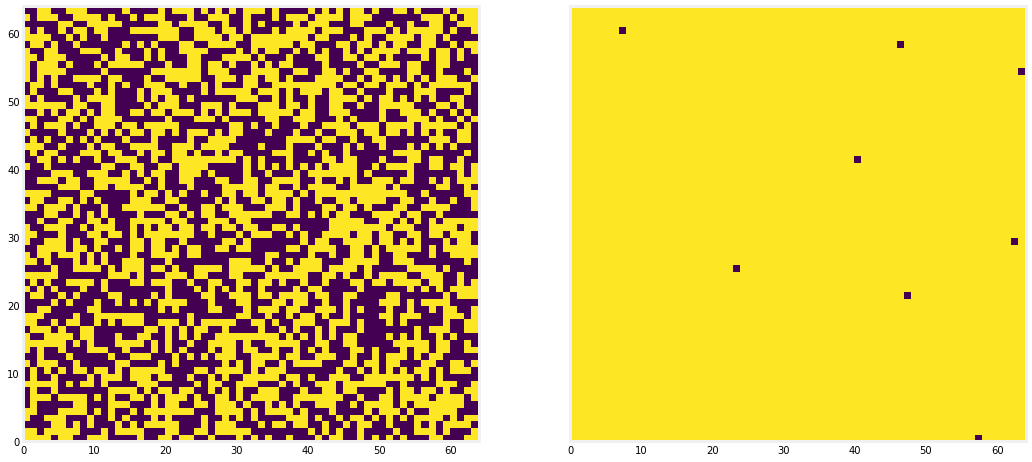

In [13]:
# temperatura odpowiadająca log T ~= 0.8 odpowiada przejściu między magnetykiem a antymagnetykiem
ising(T=1.3, max_turns=500)

### model Isinga
1. ze względu na prawa fizyczne jest idealnym modelem do obserwacji przejść fazowych 
  * prawa mówią, że dla modeli o tym samym wymiarze, zachowanie przenosi się dokładnie
1. ciekawe zachowanie jest dla trójkątów
  * dla $J=1$ zachowanie będzie podobne
  * dla $J=-1$ trójki sąsiadów o tym samym spinie